# Default Risk - Home Credit Indonesia
by <br>
Name   : Ilham Zulfikri Firdaus <br>
E-mail : ilham.zulfikri.f@mail.ugm.ac.id

## Load Data

We are using pandas to load our dataset. We limit the data, so it only read the first 10000 rows and 16 columns. Since, we saves computation cost.

In [26]:
import pandas as pd
import numpy as np
data = pd.read_csv('./home-credit-default-risk/application_train.csv', nrows=10000)
data = data.iloc[:,:16]
data = data.drop(columns=['SK_ID_CURR'])
data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment


# Data Preprocessing

You know that the algorithm can only process number. So We need a set of processing stuff to do with our data.
- Change value of XNA to approriate NaN format
- Drop unsignificant feature (where it only have 1 unique value troughout a field)
- Handling Missing Value

## Change XNA to NaN

we replace the value of 'XNA' on all of columns into approriate format. e.g. null, NaN. In this case, we use np.nan to convert it into approriate format.

In [27]:
temp = pd.DataFrame({},index=[])
for i in range(len(data.dtypes.index)):
    #print(data.dtypes.index[i])
    #loop = data[data.dtypes.index[i]].apply(lambda x: np.nan if x == 'XNA' else x) 
    loop = data[data.dtypes.index[i]].replace('XNA', np.nan)
    if i+1 == len(data.dtypes):
        break
    temp =  pd.concat([temp, loop], axis=1)
data = temp.copy()

In [29]:
data.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married


## Drop Unsignificant Feature

Some feature might have only 1 unique value. Since it doesn't has effect to the target, we can drop it.

In [30]:
for i in range(len(data.dtypes)):
    if len(data.iloc[:,i].unique()) < 2:
        print(data.dtypes.index[i],len(data.iloc[:,i].unique()),'DROPPED')
        data = data.drop(columns=[data.dtypes.index[i]])
    else:
        print(data.dtypes.index[i],len(data.iloc[:,i].unique()))

TARGET 2
NAME_CONTRACT_TYPE 2
CODE_GENDER 2
FLAG_OWN_CAR 2
FLAG_OWN_REALTY 2
CNT_CHILDREN 8
AMT_INCOME_TOTAL 306
AMT_CREDIT 1846
AMT_ANNUITY 4200
AMT_GOODS_PRICE 365
NAME_TYPE_SUITE 8
NAME_INCOME_TYPE 5
NAME_EDUCATION_TYPE 5
NAME_FAMILY_STATUS 5


## Handling Missing Value

Missing value is pretty complicated to handle. Some of algorithm can't handle missing value. In this case, we are using Weight of Evidence. That method can convert missing value into numerical value. of course, all of value will be affected from this conversion.

### WOE_IV Feature Function

In [31]:
def WOE_IV(X, Y, n, data_type):
    data_temp = pd.DataFrame({"X": X, "Y": Y})
    
    
    calculate = data_temp[['X','Y']][data_temp.X.notnull()]
    table = pd.DataFrame({},index=[])
    
    if (data_type=='object') | (len(Y.unique()) < 2):
        table_temp = calculate.groupby('X', as_index=True)
        
        table["COUNT"] = table_temp.count().Y
        table["MAX_VALUE"] = table["MIN_VALUE"] = table_temp.sum().Y.index
    else:
        table_temp = pd.DataFrame({'X': X,'Y' : Y,'BIN': pd.qcut(calculate.X, n,duplicates='drop')}).groupby('BIN', as_index=True)
        
        table["MIN_VALUE"] = table_temp.min().X
        table["MAX_VALUE"] = table_temp.max().X
        table["COUNT"] = table_temp.count().Y
        
    
    table["EVENT"] = table_temp.sum().Y
    table["NONEVENT"] = table_temp.count().Y - table_temp.sum().Y
    table=table.reset_index(drop=True)
    
    nan = data_temp[['X','Y']][data_temp.X.isnull()]
    
    if len(nan.index) > 0:
        table_nan = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        table_nan["MAX_VALUE"] = np.nan
        table_nan["COUNT"] = nan.count().Y
        table_nan["EVENT"] = nan.sum().Y
        table_nan["NONEVENT"] = nan.count().Y - nan.sum().Y
        table = table.append(table_nan,ignore_index=True)
    
    table["EVENT_RATE"] = table.EVENT/table.COUNT
    table["NON_EVENT_RATE"] = table.NONEVENT/table.COUNT
    table["DIST_EVENT"] = table.EVENT/table.sum().EVENT + 0.0001
    table["DIST_NON_EVENT"] = table.NONEVENT/table.sum().NONEVENT + 0.0001
    table["WOE"] = np.log(table.DIST_EVENT/table.DIST_NON_EVENT)
    #table["IV"] = (table.DIST_EVENT-table.DIST_NON_EVENT)*np.log(table.DIST_EVENT/table.DIST_NON_EVENT)
    
    return(table)

Apply the function above into our dataset

### WOE_IV Feature Calculation

In [33]:
woe = pd.DataFrame({},index=[])
for i in range(len(data.dtypes)):
    print(data.dtypes.index[i+1],len(data.iloc[:,i+1].unique()))
    temp = WOE_IV(data.iloc[:,i+1],data.iloc[:,0],15,data_type=data.dtypes[i+1])
    temp ["VAR_NAME"] = data.dtypes.index[i+1]
    woe = woe.append(temp)
    if i+2 == len(data.dtypes):
        break
woe = woe [['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE']].reset_index(drop=True)

NAME_CONTRACT_TYPE 2
CODE_GENDER 2
FLAG_OWN_CAR 2
FLAG_OWN_REALTY 2
CNT_CHILDREN 8
AMT_INCOME_TOTAL 306
AMT_CREDIT 1846
AMT_ANNUITY 4200
AMT_GOODS_PRICE 365
NAME_TYPE_SUITE 8
NAME_INCOME_TYPE 5
NAME_EDUCATION_TYPE 5
NAME_FAMILY_STATUS 5


show the calculation WOE into table

In [35]:
pd.set_option('display.max_rows', 300)
woe
#woe.sort_values(by=['WOE'])

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE
0,NAME_CONTRACT_TYPE,Cash loans,Cash loans,9005,728.0,0.080844,8277.0,0.919156,0.939455,0.897336,0.045870
1,NAME_CONTRACT_TYPE,Revolving loans,Revolving loans,995,47.0,0.047236,948.0,0.952764,0.060745,0.102864,-0.526723
2,CODE_GENDER,F,F,6589,438.0,0.066474,6151.0,0.933526,0.565261,0.666875,-0.165315
3,CODE_GENDER,M,M,3411,337.0,0.098798,3074.0,0.901202,0.434939,0.333325,0.266087
4,FLAG_OWN_CAR,N,N,6662,532.0,0.079856,6130.0,0.920144,0.686552,0.664599,0.032498
5,FLAG_OWN_CAR,Y,Y,3338,243.0,0.072798,3095.0,0.927202,0.313648,0.335601,-0.067651
6,FLAG_OWN_REALTY,N,N,3025,252.0,0.083306,2773.0,0.916694,0.325261,0.300696,0.078528
7,FLAG_OWN_REALTY,Y,Y,6975,523.0,0.074982,6452.0,0.925018,0.674939,0.699504,-0.035749
8,CNT_CHILDREN,0,1,9013,674.0,0.074781,8339.0,0.925219,0.869777,0.904057,-0.038655
9,CNT_CHILDREN,2,2,833,88.0,0.105642,745.0,0.894358,0.113648,0.080859,0.340405


### Replace The Feature Value with WOE_IV

Replace the original value in the datase with the calculate WOE. the following code acts like VLOOKUP and HLOOKUP from excel.

In [41]:
#dummy = pd.DataFrame({},index=[])
dummy = data.copy()
for i in range(len(data.dtypes.index)):
    print(data.dtypes.index[i+1])
    
    if data.dtypes[i+1] == 'object':
        dummy[data.dtypes.index[i+1]] = data[data.dtypes.index[i+1]].apply(lambda x: float(woe[woe['VAR_NAME']==data.dtypes.index[i+1]].loc[(woe[woe['VAR_NAME']==data.dtypes.index[i+1]]['MIN_VALUE'].isnull()) | (woe[woe['VAR_NAME']==data.dtypes.index[i+1]]['MIN_VALUE'] == x)]['WOE'].reset_index(drop=True)[0]))
    else:
        dummy[data.dtypes.index[i+1]] = data[data.dtypes.index[i+1]].apply(lambda x: float(woe[woe['VAR_NAME']==data.dtypes.index[i+1]].loc[((woe[woe['VAR_NAME']==data.dtypes.index[i+1]]['MIN_VALUE'] <= x) | (woe[woe['VAR_NAME']==data.dtypes.index[i+1]]['MIN_VALUE'].isnull())) & ((woe[woe['VAR_NAME']==data.dtypes.index[i+1]]['MAX_VALUE'] >= x) | (woe[woe['VAR_NAME']==data.dtypes.index[i+1]]['MAX_VALUE'].isnull()))]["WOE"].reset_index(drop=True)[0])) 

    if i+2 == len(data.dtypes):
        break
    #dummy =  pd.concat([dummy, loop], axis=1)

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS


check the dataset after VLOOKUP and HLOOKUP process.

In [43]:
dummy.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS
0,1,0.045870,0.266087,0.032498,-0.035749,-0.038655,0.105078,0.237798,0.093497,0.294450,0.030087,0.198566,0.131166,0.150380
1,0,0.045870,-0.165315,0.032498,0.078528,-0.038655,-0.256922,-0.712911,0.123618,-0.856559,-0.074367,-0.450700,-0.613894,-0.067670
2,0,-0.526723,0.266087,-0.067651,-0.035749,-0.038655,-0.205072,-0.357363,-0.380860,-0.411412,0.030087,0.198566,0.131166,0.150380
3,0,0.045870,-0.165315,0.032498,-0.035749,-0.038655,0.129757,0.280851,0.221045,0.294450,0.030087,0.198566,0.131166,0.229441
4,0,0.045870,0.266087,0.032498,-0.035749,-0.038655,0.129757,0.169324,-0.097559,-0.187589,0.030087,0.198566,0.131166,0.150380


### Save file to csv

In [44]:
dummy.to_csv('train_woe_15features_10krows.csv')

### Read existing csv file

In [3]:
import pandas as pd
import numpy as np
dummy = pd.read_csv('train_woe_15features_10krows.csv', index_col='Unnamed: 0')
#dummy = dummy.replace([np.inf, -np.inf], 0)

In [45]:
dummy.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS
0,1,0.045870,0.266087,0.032498,-0.035749,-0.038655,0.105078,0.237798,0.093497,0.294450,0.030087,0.198566,0.131166,0.150380
1,0,0.045870,-0.165315,0.032498,0.078528,-0.038655,-0.256922,-0.712911,0.123618,-0.856559,-0.074367,-0.450700,-0.613894,-0.067670
2,0,-0.526723,0.266087,-0.067651,-0.035749,-0.038655,-0.205072,-0.357363,-0.380860,-0.411412,0.030087,0.198566,0.131166,0.150380
3,0,0.045870,-0.165315,0.032498,-0.035749,-0.038655,0.129757,0.280851,0.221045,0.294450,0.030087,0.198566,0.131166,0.229441
4,0,0.045870,0.266087,0.032498,-0.035749,-0.038655,0.129757,0.169324,-0.097559,-0.187589,0.030087,0.198566,0.131166,0.150380


# Feature Selection

Not all of the feature have good effect to the model. We are going to selecting only the good feature. In this case, we will check the relationship between feature with Collinearity and Feature Importance

### Collinearity checking

In [46]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dummy.iloc[:,1:].values, i) for i in range(dummy.iloc[:,1:].shape[1])]
vif["features"] = dummy.iloc[:,1:].columns
vif = vif.sort_values(by='VIF Factor',ascending=False)
vif = vif [['features','VIF Factor']]
vif

,features,VIF Factor
6,AMT_CREDIT,1.916522
8,AMT_GOODS_PRICE,1.709385
7,AMT_ANNUITY,1.277376
2,FLAG_OWN_CAR,1.166621
1,CODE_GENDER,1.163519
0,NAME_CONTRACT_TYPE,1.083632
5,AMT_INCOME_TOTAL,1.076988
10,NAME_INCOME_TYPE,1.059072
11,NAME_EDUCATION_TYPE,1.043548
12,NAME_FAMILY_STATUS,1.025324


### (1) Selecting Feature 

Drop the feature with defined threshold value. In this case, we will drop the feature that has VIF value more than 5

In [47]:
threshold = 5.0
dummy = dummy.drop(columns=list(vif[vif['VIF Factor']>threshold]['features']))
dummy.head()

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS
0,1,0.045870,0.266087,0.032498,-0.035749,-0.038655,0.105078,0.237798,0.093497,0.294450,0.030087,0.198566,0.131166,0.150380
1,0,0.045870,-0.165315,0.032498,0.078528,-0.038655,-0.256922,-0.712911,0.123618,-0.856559,-0.074367,-0.450700,-0.613894,-0.067670
2,0,-0.526723,0.266087,-0.067651,-0.035749,-0.038655,-0.205072,-0.357363,-0.380860,-0.411412,0.030087,0.198566,0.131166,0.150380
3,0,0.045870,-0.165315,0.032498,-0.035749,-0.038655,0.129757,0.280851,0.221045,0.294450,0.030087,0.198566,0.131166,0.229441
4,0,0.045870,0.266087,0.032498,-0.035749,-0.038655,0.129757,0.169324,-0.097559,-0.187589,0.030087,0.198566,0.131166,0.150380


### Feature Importance

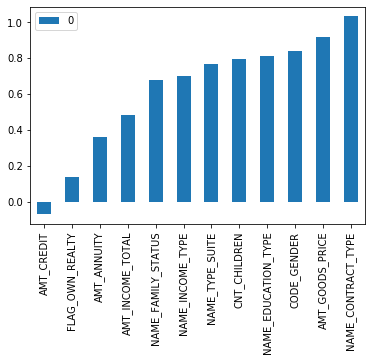

In [48]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

#dummy = pd.read_csv('train_woe_30features_10krows.csv')
X = dummy.iloc[:,1:]
y = dummy.iloc[:,0]

model = LogisticRegression(random_state = 123)
model.fit(X, y)
feature_importance = pd.DataFrame(model.coef_, columns=X.columns.values)
feature_importance.T.sort_values(by=0)[:-1].plot.bar()
plt.show()

### (2) Selecting Feature

The closest feature value to the 0, the less important feature to the prediction model. So, we make a threshold, for all of feature that have a value ranged from -0.1 to 0.1 will be deleted.

In [49]:
#feature_importance = feature_importance.T.sort_values(by=0)[:-1]
upper_threshold = 0.1
bottom_threshold = -0.1

feature_importance = feature_importance.T.sort_values(by=0)[:-1]
dummy = dummy.drop(columns=list(feature_importance.loc[(feature_importance[0]<upper_threshold) & (feature_importance[0]>bottom_threshold)].index))

### Making Dataset

after we select the feture, we split the date into 2 dataset, those are training dataset and test dataset.

In [50]:
import numpy as np
from sklearn.model_selection import train_test_split
X = dummy.iloc[:,1:]
y = dummy.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Balancing Data

### Check the Data

Imbalance could become problematic. the prediction model will tend to fit to majority class

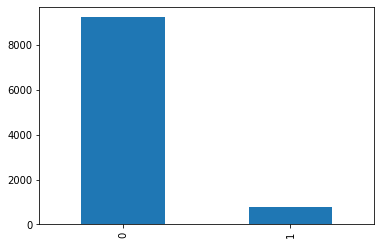

In [51]:
pd.Series(y).value_counts().plot(kind='bar')

### Data Oversampling 

We are using SMOTE method to oversampling the data.

In [52]:
from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

Plot the result

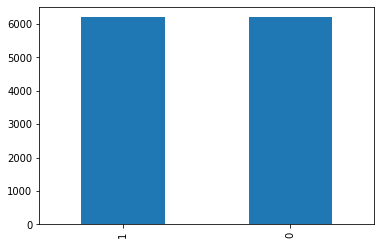

In [53]:
pd.Series(y_resampled).value_counts().plot(kind='bar')

# Model

### Logistic Regression

Let's fit the dataset with logistic regression. Since the dataset are process trough WOE

In [71]:
m = LogisticRegression(random_state = 123, max_iter= 100000, l1_ratio=0.5, penalty='elasticnet', solver = 'saga', C=0.1)
m.fit(X_resampled, y_resampled)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=0.5, max_iter=100000,
                   multi_class='auto', n_jobs=None, penalty='elasticnet',
                   random_state=123, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

# Evaluation

## Confusion Matrix

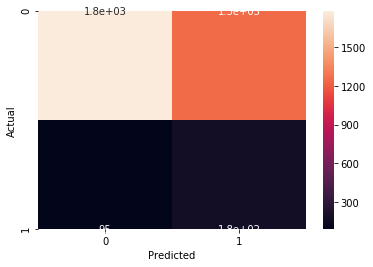

In [73]:
import seaborn as sns
y_pred = m.predict(X_test)
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

## AUC-ROC and GINI

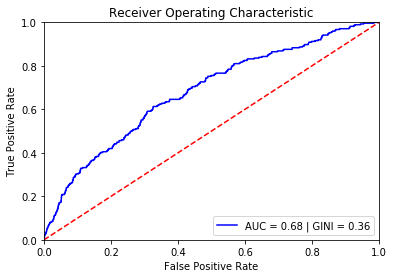

In [72]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# %matplotlib inline
probs = m.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
GINI = 2*roc_auc-1

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f | GINI = %0.2f' %(roc_auc,GINI))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()